In [171]:
%pip install numpy
%pip install matplotlib
%pip install pandas


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [172]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

In [173]:
# Keep this cell for MOGA class definition
import random
import math
import numpy as np
from typing import List, Tuple

class MOGA:
    """
    Working MOGA implementation for CVRP (giant-tour + split).
    Assumptions:
      - customer IDs are 1..N
      - depot is index 0 (not part of genome)
      - demands is a list/array of length N+1 where demands[0] == 0
      - customer_coords: list of N (x,y) tuples for customers 1..N
      - depot_coords: (x,y) tuple
    """

    def __init__(
        self,
        pop_size: int,
        crossover_rate: float,
        mutation_rate: float,
        customer_coords: List[Tuple[float, float]],
        depot_coords: Tuple[float, float],
        demands: List[float],
        capacity: float,
        max_vehicles: int,
        seed: int = 0,
    ):
        random.seed(seed)
        np.random.seed(seed)

        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

        self.customer_coords = customer_coords
        self.depot_coords = depot_coords
        self.demands = list(demands)  # demands[0] must be depot (0)
        self.capacity = capacity
        self.max_vehicles = max_vehicles

        self.N = len(customer_coords)  # number of customers
        assert len(self.demands) == self.N + 1, "demands must have length N+1 with depot at index 0"

        # distance matrix: index 0 = depot, 1..N = customers
        self.dist_matrix = self._build_distance_matrix()

        # initialize population: list of lists (permutations of 1..N)
        self.population = [self.create_individual() for _ in range(self.pop_size)]

    # ---------- Representation & Initialization ----------
    def create_individual(self) -> List[int]:
        """Return a random permutation of customers 1..N (list length N)."""
        indiv = list(range(1, self.N + 1))
        random.shuffle(indiv)
        return indiv

    # ---------- Split (greedy) ----------
    def split_customers_capacitated(self, permutation: List[int]) -> List[List[int]]:
        """
        Greedy split: scan permutation, start new route when adding next customer would exceed capacity.
        Each route is a list of customer IDs (no depot inside). Routes returned do not include depot.
        """
        routes: List[List[int]] = []
        current_route: List[int] = []
        current_load = 0

        for cust in permutation:
            d = self.demands[cust]  # demands expected to have depot at index 0
            if current_load + d > self.capacity:
                if current_route:
                    routes.append(current_route)
                current_route = [cust]
                current_load = d
            else:
                current_route.append(cust)
                current_load += d

        if current_route:
            routes.append(current_route)

        # simple repair: merge smallest routes until <= max_vehicles (greedy)
        # If merging any two smallest would exceed capacity, keep as is (we accept >max_vehicles rare case).
        while len(routes) > self.max_vehicles:
            # find two smallest by load
            loads = [sum(self.demands[c] for c in r) for r in routes]
            i1 = int(np.argmin(loads))
            r1 = routes.pop(i1)
            # recompute loads after removal
            loads = [sum(self.demands[c] for c in r) for r in routes]
            i2 = int(np.argmin(loads))
            r2 = routes.pop(i2)
            merged = r1 + r2
            if sum(self.demands[c] for c in merged) <= self.capacity:
                routes.append(merged)
            else:
                # cannot merge feasibly; put them back and stop attempting merges
                routes.append(r1)
                routes.append(r2)
                break

        return routes

    # ---------- Distance matrix & evaluation ----------
    def _build_distance_matrix(self) -> np.ndarray:
        all_coords = [self.depot_coords] + list(self.customer_coords)
        n = len(all_coords)
        D = np.zeros((n, n), dtype=float)
        for i in range(n):
            xi, yi = all_coords[i]
            for j in range(n):
                xj, yj = all_coords[j]
                D[i, j] = math.hypot(xi - xj, yi - yj)
        return D

    def evaluate_fitness(self, individual: List[int]) -> np.ndarray:
        """
        Returns two objectives:
          - total distance (sum of route lengths, each route starts/ends at depot)
          - std. dev. of route lengths
        """
        routes = self.split_customers_capacitated(individual)
        if len(routes) == 0:
            # shouldn't happen; give large penalties
            return np.array([1e9, 1e9], dtype=float)

        route_lengths = []
        for r in routes:
            prev = 0  # depot index
            length = 0.0
            for cust in r:
                length += self.dist_matrix[prev, cust]
                prev = cust
            length += self.dist_matrix[prev, 0]  # back to depot
            route_lengths.append(length)

        total_distance = float(sum(route_lengths))
        m = len(route_lengths)
        avg = total_distance / m
        sd = math.sqrt(sum((l - avg) ** 2 for l in route_lengths) / m)

        return np.array([total_distance, sd], dtype=float)

    # ---------- Non-dominated sort (fast) ----------
    def fast_non_dominated_sort(self, fitness_values: np.ndarray) -> List[List[int]]:
        pop = len(fitness_values)
        fronts: List[List[int]] = [[]]
        dominated = [[] for _ in range(pop)]
        dom_count = [0] * pop

        for p in range(pop):
            for q in range(pop):
                if p == q:
                    continue
                # p dominates q?
                if np.all(fitness_values[p] <= fitness_values[q]) and np.any(fitness_values[p] < fitness_values[q]):
                    dominated[p].append(q)
                elif np.all(fitness_values[q] <= fitness_values[p]) and np.any(fitness_values[q] < fitness_values[p]):
                    dom_count[p] += 1
            if dom_count[p] == 0:
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in dominated[p]:
                    dom_count[q] -= 1
                    if dom_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        return fronts[:-1]

    # ---------- Fitness sharing (MOGA diversity) ----------
    @staticmethod
    def sharing_function(distance: float, niche_radius: float) -> float:
        if distance < niche_radius:
            return 1.0 - (distance / niche_radius)
        return 0.0

    def calculate_niche_counts(self, fitness_values: np.ndarray, indices: List[int], niche_radius: float) -> np.ndarray:
        """
        Compute niche counts for the given subset of indices (e.g., a front).
        """
        n = len(indices)
        niche_counts = np.zeros(n, dtype=float)
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                diff = fitness_values[indices[i]] - fitness_values[indices[j]]
                dist = math.sqrt(np.sum(diff ** 2))
                niche_counts[i] += self.sharing_function(dist, niche_radius)
        return niche_counts

    # ---------- Variation operators ----------
    def order_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        size = len(parent1)
        if random.random() > self.crossover_rate:
            return parent1.copy()

        a, b = sorted(random.sample(range(size), 2))
        child = [None] * size
        # copy slice from parent1
        child[a:b+1] = parent1[a:b+1]
        # fill remaining from parent2 in order
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
                p2_idx += 1
        return child

    def swap_mutation(self, individual: List[int]) -> List[int]:
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual

    # ---------- Parent selection using MOGA (rank + sharing) ----------
    def compute_shared_fitnesses(self, fitness_values: np.ndarray, niche_radius: float = None) -> np.ndarray:
        """
        Compute a scalar 'shared fitness' for each individual.
        Approach:
          - Determine non-dominated fronts.
          - Assign base fitness by rank: f_base = 1 / (1 + rank_index)  (rank_index: 0 for best front)
          - Within each front compute niche counts and divide base fitness by (1 + niche_count).
          - Return array of length pop_size with shared fitness.
        """
        pop = len(fitness_values)
        if niche_radius is None:
            # heuristic niche radius: a small fraction of the range in objective space
            spans = fitness_values.max(axis=0) - fitness_values.min(axis=0)
            # avoid zeros
            spans[spans == 0] = 1.0
            niche_radius = 0.1 * np.linalg.norm(spans)

        fronts = self.fast_non_dominated_sort(fitness_values)
        shared = np.zeros(pop, dtype=float)

        for rank_idx, front in enumerate(fronts):
            if not front:
                continue
            base = 1.0 / (1 + rank_idx)  # higher for better (lower rank) solutions
            # compute niche counts on this front
            niche_counts = self.calculate_niche_counts(fitness_values, front, niche_radius)
            for i, ind in enumerate(front):
                shared[ind] = base / (1.0 + niche_counts[i])
        # small positive floor to avoid zeros
        shared = shared + 1e-12
        return shared

    # ---------- Evolutionary loop ----------
    def run(self, generations: int = 100, niche_radius: float = None):
        # Evaluate initial population
        fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])

        for gen in range(generations):
            # Compute shared fitnesses for parent selection
            shared_fit = self.compute_shared_fitnesses(fitness_values, niche_radius)

            # Keep old population for elitism
            old_population = self.population.copy()
            old_fitness_values = fitness_values.copy()

            # Sample parents and create offspring
            new_pop = []
            while len(new_pop) < self.pop_size:
                idx_parents = np.random.choice(
                    self.pop_size, size=2, replace=False, p=shared_fit / shared_fit.sum()
                )
                p1 = self.population[idx_parents[0]]
                p2 = self.population[idx_parents[1]]
                child = self.order_crossover(p1, p2)
                child = self.swap_mutation(child)
                new_pop.append(child)

            # Evaluate new population
            self.population = new_pop
            fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])

            # Elitism: keep best individual from previous generation
            fronts = self.fast_non_dominated_sort(old_fitness_values)
            elite_idx = fronts[0][0]  # first individual in best front
            # Replace worst individual in new population
            shared_fit_new = self.compute_shared_fitnesses(fitness_values, niche_radius)
            worst_idx = np.argmin(shared_fit_new)
            self.population[worst_idx] = old_population[elite_idx]
            fitness_values[worst_idx] = old_fitness_values[elite_idx]

            if gen % 50 == 0 or gen == generations-1:
                print(f"Generation {gen}: Best distance = {fitness_values[elite_idx][0]:.2f}, SD = {fitness_values[elite_idx][1]:.2f}")

        # After all generations, return Pareto front
        fronts = self.fast_non_dominated_sort(fitness_values)
        pareto_inds = fronts[0] if fronts else []
        pareto_solutions = [self.population[i] for i in pareto_inds]
        pareto_fitnesses = fitness_values[pareto_inds] if len(pareto_inds) > 0 else np.array([])
        return pareto_solutions, pareto_fitnesses


    def get_population_fitness(self):
        return np.array([self.evaluate_fitness(ind) for ind in self.population])



In [174]:
def read_cvrp(file_path):
    instance_data = {'coordinates': {}, 'demands': {}, 'depot': None, 'capacity': None}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    section = None
    for line in lines:
        line = line.strip()
        if line.startswith('CAPACITY'):
            instance_data['capacity'] = int(line.split(':')[1])
        elif line.startswith('NODE_COORD_SECTION'):
            section = 'coords'
        elif line.startswith('DEMAND_SECTION'):
            section = 'demands'
        elif line.startswith('DEPOT_SECTION'):
            section = 'depot'
        elif line == 'EOF' or line == '':
            continue
        elif section == 'coords':
            parts = line.split()
            instance_data['coordinates'][int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == 'demands':
            parts = line.split()
            instance_data['demands'][int(parts[0])] = int(parts[1])
        elif section == 'depot':
            if line == '-1':
                continue
            instance_data['depot'] = int(line)
    return instance_data

def prepare_instance(instance_data):
    coords = instance_data['coordinates']
    demands = instance_data['demands']
    depot_id = instance_data['depot']
    capacity = instance_data['capacity']
    depot_coords = coords[depot_id]
    customer_ids = sorted([i for i in coords.keys() if i != depot_id])
    customer_coords = np.array([coords[i] for i in customer_ids], dtype=float)
    demand_array = np.zeros(len(customer_ids) + 1, dtype=float)
    for idx, cid in enumerate(customer_ids):
        demand_array[idx + 1] = demands[cid]
    return depot_coords, customer_coords, demand_array, capacity

def plot_pareto_front(pareto_fits, title="MOGA Pareto Front"):
    pareto_fits = np.array(pareto_fits)
    import matplotlib.pyplot as plt

    # Sort points for nicer line plot
    sorted_idx = np.argsort(pareto_fits[:,0])
    pareto_sorted = pareto_fits[sorted_idx]

    plt.figure(figsize=(7,5))
    # Line plot
    plt.plot(pareto_sorted[:,0], pareto_sorted[:,1], '-o', color='red', alpha=0.7, label="Pareto Front")
    # Scatter plot
    plt.scatter(pareto_fits[:,0], pareto_fits[:,1], c='blue', s=60, alpha=0.7, label="Solutions")

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (Std Dev)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def plot_all_fronts(all_fronts, global_front, title="Pareto Fronts Across Runs"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 5))

    # Plot all run-specific fronts (faint blue)
    for front in all_fronts:
        if len(front) > 0:
            plt.scatter(front[:, 0], front[:, 1],
                        c="blue", alpha=0.3, s=30, label="_nolegend_")

    # Plot global Pareto front (highlighted red line)
    sorted_idx = np.argsort(global_front[:, 0])
    global_sorted = global_front[sorted_idx]
    plt.plot(global_sorted[:, 0], global_sorted[:, 1],
             "-o", color="red", lw=2, ms=6, label="Global Pareto Front")

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (Std Dev)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [ ]:
# Example usage for any CVRPLIB .vrp file:
instance_file = "A-n32-k5.vrp"
instance = read_cvrp(instance_file)
depot_coords, customer_coords, demands, capacity = prepare_instance(instance)

'\nmoga = MOGA(\n    pop_size=100,\n    crossover_rate=0.7,\n    mutation_rate=0.2,\n    customer_coords=customer_coords,\n    depot_coords=depot_coords,\n    demands=demands,\n    capacity=capacity,\n    max_vehicles=5,\n    seed=42\n)\npareto_sols, pareto_fits = moga.run(generations=500)\nprint("Pareto front:")\nfor sol, fit in zip(pareto_sols, pareto_fits):\n    print("Permutation:", sol, "Fitness:", fit)\nplot_pareto_front(pareto_fits)\n'

In [176]:
def run_experiment(file_path, pop_size=50, generations=200, runs=20, max_vehicles=5):
    """
    Run MOGA multiple times on a CVRP instance and collect results.

    Args:
        file_path (str): Path to .vrp file.
        pop_size (int): Population size.
        generations (int): Number of generations per run.
        runs (int): How many times to repeat with different seeds.
        max_vehicles (int): Vehicle limit.

    Returns:
        all_fronts: list of Pareto fitness arrays (one per run).
        global_front: merged non-dominated front from all runs.
    """
    raw = read_cvrp(file_path)
    depot_coords, customer_coords, demands, capacity = prepare_instance(raw)

    all_fronts = []

    for run in range(runs):
        print(f"\n=== Run {run+1}/{runs} ===")
        moga = MOGA(
            pop_size=pop_size,
            crossover_rate=0.8,
            mutation_rate=0.2,
            customer_coords=customer_coords,
            depot_coords=depot_coords,
            demands=demands,
            capacity=capacity,
            max_vehicles=max_vehicles,
            seed=run,  # different seed per run
        )
        pareto_sols, pareto_fits = moga.run(generations=generations)
        all_fronts.append(pareto_fits)

    # Merge all solutions into one big pool
    all_points = np.vstack(all_fronts)
    
    # Extract non-dominated front from merged results
    def nondominated(points: np.ndarray) -> np.ndarray:
        """Return only non-dominated points from a set of objective vectors."""
        n = len(points)
        is_efficient = np.ones(n, dtype=bool)
        for i in range(n):
            if not is_efficient[i]:
                continue
            # Check if any point dominates points[i]
            dominates = np.all(points <= points[i], axis=1) & np.any(points < points[i], axis=1)
            if np.any(dominates):
                is_efficient[i] = False
        return points[is_efficient]


    global_front = nondominated(all_points)

    print(f"\nFinished {runs} runs. Global Pareto front size: {len(global_front)}")

    return all_fronts, global_front



=== Run 1/3 ===
Generation 0: Best distance = 2093.82, SD = 81.33
Generation 50: Best distance = 1423.26, SD = 37.49
Generation 100: Best distance = 1251.92, SD = 22.99
Generation 150: Best distance = 1336.66, SD = 50.77
Generation 200: Best distance = 1367.99, SD = 55.15
Generation 250: Best distance = 1052.20, SD = 72.85
Generation 300: Best distance = 1296.53, SD = 49.05
Generation 350: Best distance = 1387.82, SD = 40.60
Generation 400: Best distance = 1012.17, SD = 63.61
Generation 450: Best distance = 1119.69, SD = 24.70
Generation 499: Best distance = 1308.59, SD = 107.25

=== Run 2/3 ===
Generation 0: Best distance = 1955.44, SD = 93.58
Generation 50: Best distance = 1491.21, SD = 48.21
Generation 100: Best distance = 1434.34, SD = 52.80
Generation 150: Best distance = 1453.87, SD = 91.05
Generation 200: Best distance = 1130.45, SD = 39.19
Generation 250: Best distance = 1320.98, SD = 4.68
Generation 300: Best distance = 1326.68, SD = 5.28
Generation 350: Best distance = 1290.

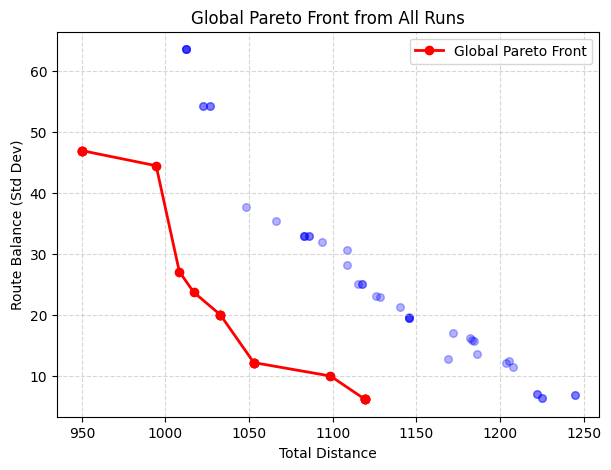

In [ ]:
all_fronts, global_front = run_experiment(
    file_path=instance_file,
    pop_size=100,
    generations=500,
    runs=20,
    max_vehicles=5,
)
plot_all_fronts(all_fronts, global_front, title="Global Pareto Front from All Runs")

In [ ]:
def dominates(p_fitness, q_fitness):
    return all(p <= q for p, q in zip(p_fitness, q_fitness)) and \
           any(p < q for p, q in zip(p_fitness, q_fitness))

def non_dominated_sorting(fitness_values):
    population_size = len(fitness_values)
    domination_counts = [0] * population_size
    dominated_solutions = [[] for _ in range(population_size)]
    ranks = [0] * population_size
    fronts = [[]]

    for p in range(population_size):
        for q in range(population_size):
            if p == q:
                continue
            if dominates(fitness_values[p], fitness_values[q]):
                dominated_solutions[p].append(q)
            elif dominates(fitness_values[q], fitness_values[p]):
                domination_counts[p] += 1

        if domination_counts[p] == 0:
            ranks[p] = 1
            fronts[0].append(p)

    current_front = 0
    while fronts[current_front]:
        next_front = []
        for p in fronts[current_front]:
            for q in dominated_solutions[p]:
                domination_counts[q] -= 1
                if domination_counts[q] == 0:
                    ranks[q] = current_front + 2
                    next_front.append(q)
        current_front += 1
        fronts.append(next_front)

    return fronts[:-1]

def calculate_crowding_distance(fitness_values, front):
    n = len(front)
    if n == 0:
        return np.array([])
    if n == 1:
        return np.array([float("inf")])

    distances = np.zeros(n)
    num_objectives = len(fitness_values[0])

    for obj in range(num_objectives):
        sorted_idx = sorted(range(n), key=lambda i: fitness_values[front[i]][obj])

        distances[sorted_idx[0]] = float("inf")
        distances[sorted_idx[-1]] = float("inf")

        f_min = fitness_values[front[sorted_idx[0]]][obj]
        f_max = fitness_values[front[sorted_idx[-1]]][obj]

        if f_max == f_min:
            continue

        for j in range(1, n - 1):
            prev_val = fitness_values[front[sorted_idx[j - 1]]][obj]
            next_val = fitness_values[front[sorted_idx[j + 1]]][obj]
            distances[sorted_idx[j]] += (next_val - prev_val) / (f_max - f_min)

    return distances
